In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-5a4wm_ph
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-5a4wm_ph
  Resolved https://github.com/tensorflow/docs to commit e520630d1505d122c4e1fb0e266eff1976f5b7dc
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.4.23.84782-py3-none-any.whl size=182536 sha256=020116a447683e1e063ce5d96586814f58ce1d8954430e4dd8ec96ea38b1d4b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-7kj6sumw/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import io
import PIL
from tensorflow.keras import layers
import time
import cv2
from IPython import display
from PIL import Image

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving 1.jpg to 1.jpg
Saving 2.jpg to 2.jpg
Saving 3.jpg to 3.jpg
Saving 4.jpg to 4.jpg
Saving 5.jpg to 5.jpg
Saving 6.jpg to 6.jpg
Saving 7.jpg to 7.jpg
Saving 8.jpg to 8.jpg
Saving 9.jpg to 9.jpg
Saving 10.jpg to 10.jpg
Saving 11.jpg to 11.jpg
Saving 12.jpg to 12.jpg
Saving 13.jpg to 13.jpg
Saving 14.jpg to 14.jpg
Saving 15.jpg to 15.jpg


In [ ]:
# Función para cargar las imágenes
def load_images(file_names):
    images = []
    for file_name in file_names:
        image = cv2.imdecode(np.frombuffer(uploaded[file_name], np.uint8), -1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir a formato RGB
        images.append(image)
    return images

In [ ]:
# Obtener los nombres de archivo de las imágenes subidas
file_names = uploaded.keys()

In [ ]:
# Cargar las imágenes
images = load_images(uploaded)

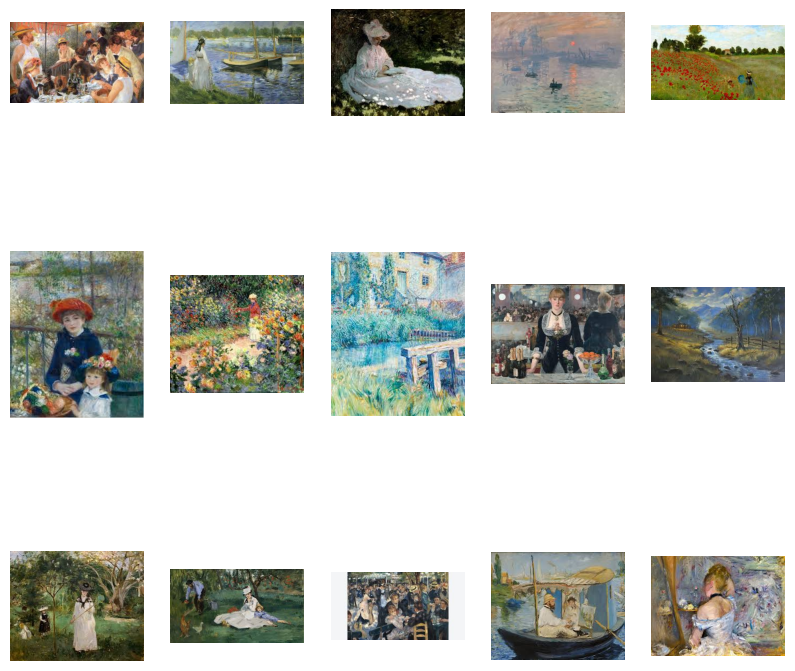

In [ ]:
# Visualizar las imágenes
plt.figure(figsize=(10, 10))
for i in range(len(images)):
    plt.subplot(3, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [ ]:
# Cargar las imágenes y convertirlas a un arreglo numpy
images = []
for file_name, content in uploaded.items():
    img = Image.open(io.BytesIO(content))

    # Redimensionar las imágenes a 28x28
    img = img.resize((28, 28))

    # Convertir las imágenes a escala de grises
    img = img.convert('L')

    # Convertir las imágenes a un arreglo numpy
    img_array = np.array(img)

    images.append(img_array)




In [ ]:
# Convertir la lista de imágenes a un arreglo numpy
images = np.array(images)

In [ ]:
# Normalizar las imágenes al rango [-1, 1]
images = (images.astype('float32') - 127.5) / 127.5

In [ ]:
# Crear un conjunto de datos a partir de mis imágenes
BUFFER_SIZE = len(images)
BATCH_SIZE = 256


In [ ]:
print("Valor de BUFFER_SIZE:", BUFFER_SIZE)
print("Número de imágenes cargadas:", len(images))

Valor de BUFFER_SIZE: 15
Número de imágenes cargadas: 15


In [ ]:
# Mezclar y agrupar las imágenes en lotes
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

**Creación modelo**

**El generador**


In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Generador (todavía no entrenado) para crear una imagen.

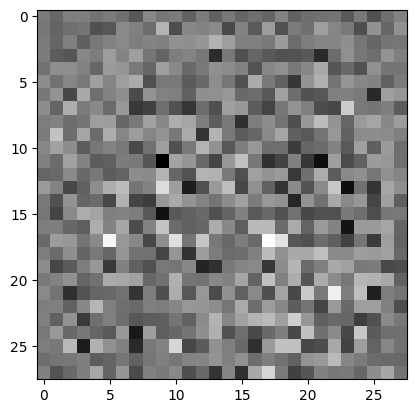

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

**El discriminador**

El discriminador es un clasificador de imágenes basado en CNN.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Clasificar las imágenes generadas como reales o falsas. Se entrenará para generar valores positivos para imágenes reales y valores negativos para imágenes falsas.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.0011842]], shape=(1, 1), dtype=float32)


**Definición de pérdida y optimizadores.**

Para ambos modelos.

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

**Pérdida de discriminador.**

Cuantifica qué tan bien el discriminador es capaz de distinguir las imágenes reales de las falsificaciones. Compara las predicciones del discriminador sobre imágenes reales con una matriz de 1 y las predicciones del discriminador sobre imágenes falsas (generadas) con una matriz de 0.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

**Pérdida del generado.**

La pérdida del generador cuantifica qué tan bien pudo engañar al discriminador. Intuitivamente, si el generador funciona bien, el discriminador clasificará las imágenes falsas como reales (o 1). Aquí, compare las decisiones de los discriminadores en las imágenes generadas con una matriz de 1.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Los optimizadores discriminador y generador son diferentes ya que entrenará dos redes por separado.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

**Guardado puntos de control.**

Este cuaderno también demuestra cómo guardar y restaurar modelos, lo que puede ser útil en caso de que se interrumpa una tarea de entrenamiento de larga duración.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

**Definir el ciclo de entrenamiento.**

In [ ]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

El ciclo de entrenamiento comienza cuando el generador recibe una semilla aleatoria como entrada. Esa semilla se usa para producir una imagen. Luego, el discriminador se usa para clasificar imágenes reales (extraídas del conjunto de entrenamiento) e imágenes falsas (producidas por el generador). La pérdida se calcula para cada uno de estos modelos y los gradientes se utilizan para actualizar el generador y el discriminador.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generar y guardar imágenes.**

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

**Entrenamiento modelo.**

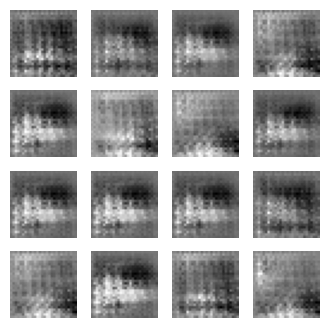

In [ ]:
train(train_dataset, EPOCHS)

Restaurar el último punto de control.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

**Crear un GIF.**

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

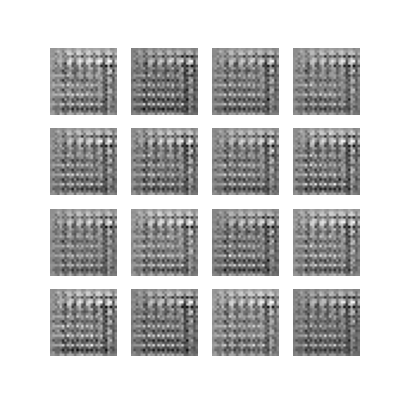

In [ ]:
display_image(EPOCHS)

Imageio para crear un gif animado usando las imágenes guardadas durante el entrenamiento.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-33-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-33-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



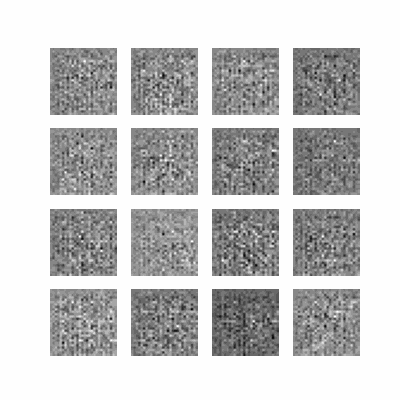

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)